In [22]:
import argparse
from pathlib import Path
import time
import cv2
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
from utils.annotationdataset import AnnotationDataset
from utils.annotationimage import AnnotationImage, AnnotationObject
from utils.annotationscene import AnnotationScene
from utils.voxelgrid import VoxelGrid
import pandas as pd
import pickle
from scipy.spatial.distance import cdist


In [23]:
sam_checkpoint = "model_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [24]:
scene = AnnotationScene(None, None, None, None, None)
scene.scene_from_pickle("debug_data_promptgeneration")

In [25]:
scene.voxel_grid.identify_voxels_in_scene(scene)

calculating correspondences for image
projection time: 0.29024767875671387
loop time: 0.09652256965637207
correspondence time: 0.39909863471984863
calculating correspondences for image
projection time: 0.34122800827026367
loop time: 0.0666654109954834
correspondence time: 0.41895294189453125
calculating correspondences for image
projection time: 0.30587291717529297
loop time: 0.06438708305358887
correspondence time: 0.38069748878479004
calculating correspondences for image
projection time: 0.3421907424926758
loop time: 0.06656098365783691
correspondence time: 0.41899633407592773
calculating correspondences for image
projection time: 0.3235311508178711
loop time: 0.06888175010681152
correspondence time: 0.4024176597595215
calculating correspondences for image
projection time: 0.32138681411743164
loop time: 0.07041645050048828
correspondence time: 0.40203022956848145
majority voting with neighborhood analysis
(136, 136, 136)
get_neighborhood_votes
combine neighborhood votes with majority

In [26]:
def get_prompt_points_from_mask(mask, debug_visualization=True, single_point=False):

    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # # use closing to fill in holes
    # mask = cv2.dilate(mask, kernel, iterations=3)
    # mask = cv2.erode(mask, kernel, iterations=3)

    # cv2.imshow("mask2", mask)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    skeleton = cv2.ximgproc.thinning(mask)
    all_points = []  

    if single_point:
        segment_points = np.argwhere(skeleton > 0)
        segment_points = segment_points.reshape(-1, 2)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, _, centers = cv2.kmeans(segment_points.astype(np.float32), 1, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
        distances = cdist(centers, segment_points)
        closest_point_indices = np.argmin(distances, axis=1)  # Find closest for EACH center
        snapped_centers = segment_points[closest_point_indices]
        all_points.extend(snapped_centers)
    else:
        num_labels, labels = cv2.connectedComponents(skeleton)
        num_points_per_segment = 1

        #get num of points in each segment
        points = np.unique(labels, return_counts=True)[1]
        num_points_per_segment = np.maximum(np.ceil(points / 300), 1).astype(np.int32)

        all_points = []  
        for label in range(1, num_labels):  # Start at 1 to skip the background label (0)
            segment_mask = (labels == label).astype(np.uint8)
            segment_points = np.argwhere(segment_mask > 0)
            segment_points = segment_points.reshape(-1, 2)

            if len(segment_points) > num_points_per_segment[label]:
                # Perform k-means
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
                _, _, centers = cv2.kmeans(segment_points.astype(np.float32), num_points_per_segment[label], None, criteria, 10, cv2.KMEANS_PP_CENTERS)

                # Snap centers to nearest skeleton points (corrected)
                distances = cdist(centers, segment_points)
                closest_point_indices = np.argmin(distances, axis=1)  # Find closest for EACH center
                snapped_centers = segment_points[closest_point_indices]
                all_points.extend(snapped_centers)

            elif len(segment_points) > 0:
                # If too few points for k-means, still include one
                center_index = np.random.choice(len(segment_points)) 
                all_points.append(segment_points[center_index])

        centers = np.array(all_points, dtype=np.int32)

    if debug_visualization:
        print("WTF")
        plt.figure(figsize=(10,10))
        plt.imshow(mask)
        plt.imshow(skeleton, cmap='gray', alpha=0.5)
        plt.scatter(centers[:, 1], centers[:, 0], c='r', s=100)
        plt.axis('off')
        plt.show()
        #plt savefig
        # plt.savefig('skeleton_img.png')

    return centers

In [27]:
def generate_auto_prompts(image, scene, predictor):
    '''
    takes an annotation object and generates prompts for it
    '''

    #1. generate mask from voxelgrid
    # -> get new segmentation map from voxelgrid (use offscreen rednerer project to pose)
    voxelgrid = scene.voxel_grid
    voxelgrid_segmap = voxelgrid.project_voxelgrid(scene.img_width, scene.img_height, scene.camera_intrinsics, image.camera_pose, voxelgrid.o3d_grid_id)
    voxelgrid_segmap = voxelgrid_segmap[:,:,0]
    #TODO add annotation_objects to scene_ids-> assign scene ids

    #plt voxelgrid_segmap
    #set figure size big 
    plt.figure(figsize=(20, 20))
    plt.imshow(voxelgrid_segmap)
    plt.show()

    #2. for every object in annotation object

    print("generating prompts")

    for obj in image.annotation_objects.values():
        if obj.mask is not None:
            print("mask not none")
            continue
        mask = np.zeros_like(voxelgrid_segmap)
        mask[voxelgrid_segmap == obj.scene_object_id] = 255
        
        #3. generate prompts
        prompt_points = get_prompt_points_from_mask(mask, debug_visualization=True)

        # visualize prompt point on rgb image
        img = cv2.imread(image.rgb_path)
        for point in prompt_points:
            cv2.circle(img, (point[1], point[0]), 3, (0, 255, 0), -1)

        for point in prompt_points:
            image.active_object = obj
            image.add_prompt([[point[1], point[0]]], [1], predictor)

        for scene_object_id in scene.scene_object_ids:
            if scene_object_id != obj.scene_object_id:
                mask = np.zeros_like(voxelgrid_segmap)
                mask[voxelgrid_segmap == scene_object_id] = 255

                prompt_points = get_prompt_points_from_mask(mask, debug_visualization=True, single_point=True)
                for point in prompt_points:
                    image.active_object = obj
                    image.add_prompt([[point[1], point[0]]], [0], predictor)
    print("prompts generated")
    # -> get mask from segmentation map
    # -> generate positive prompts using get_prompt_points_from_mask
    # -> generate negative prompts using get_prompt_points_from_mask for all other objects

    # 3. for each prompt
    # -> add prompt to annotation object using add_prompt

    #TODO on write update obejcts.library
    img = image.generate_visualization()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.show()

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x1060de3d0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
[[ 0.5370889   0.55939253 -0.63136005  0.42394381]
 [-0.84319613  0.37695579 -0.38330747  0.31029187]
 [ 0.02357549  0.73823054  0.67413639  0.59862947]
 [ 0.          0.          0.          1.        ]]


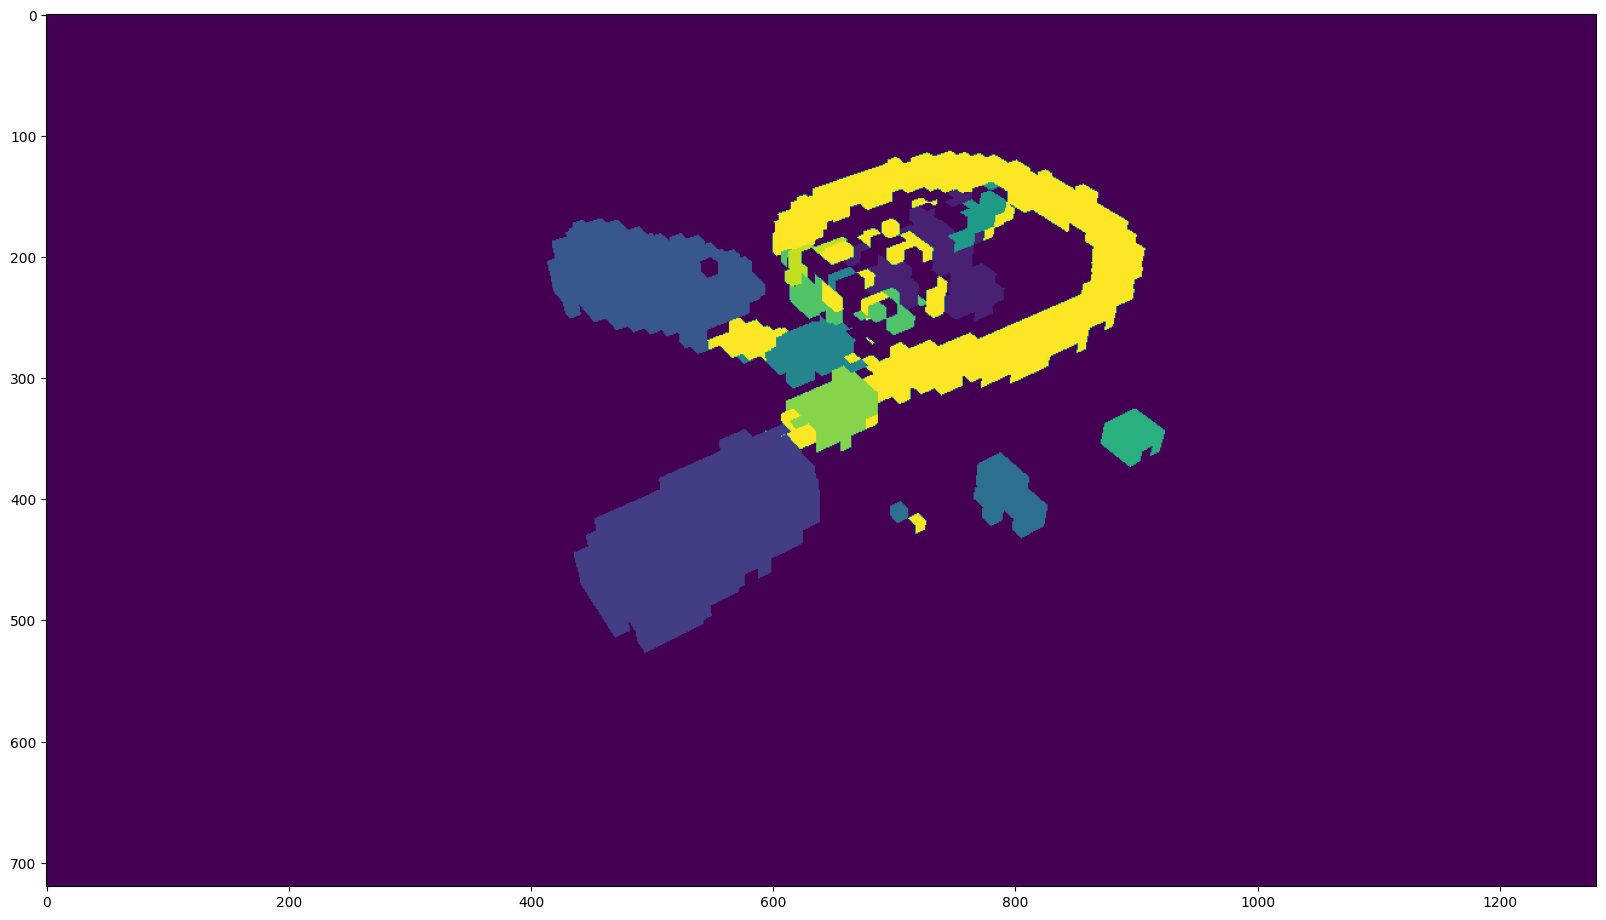

generating prompts
WTF


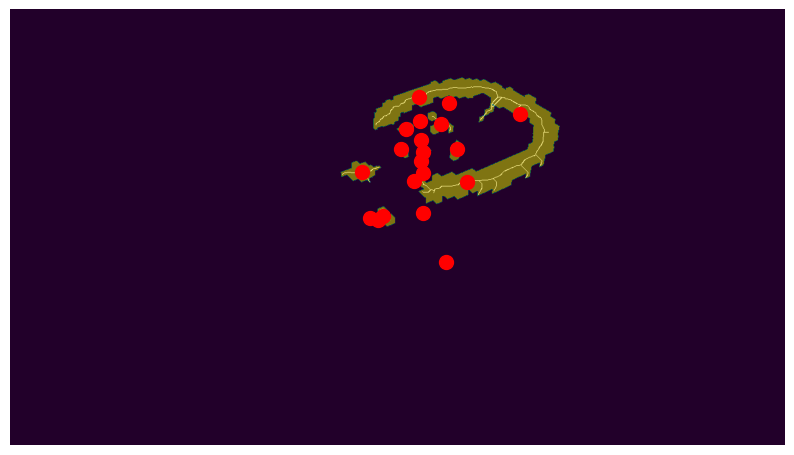

WTF


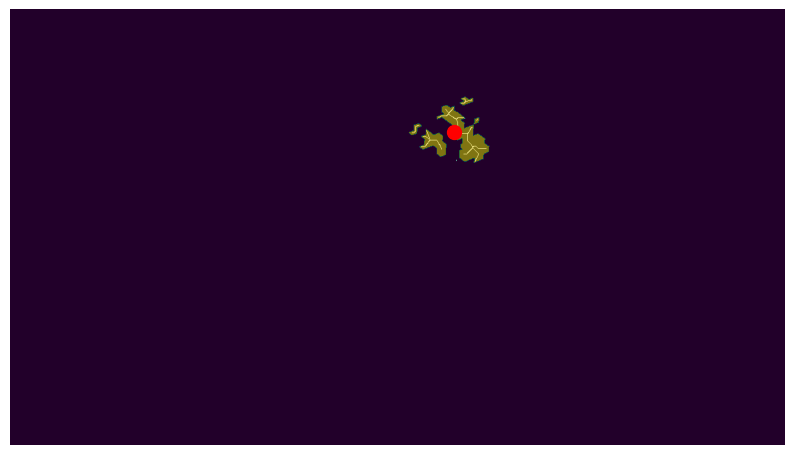

WTF


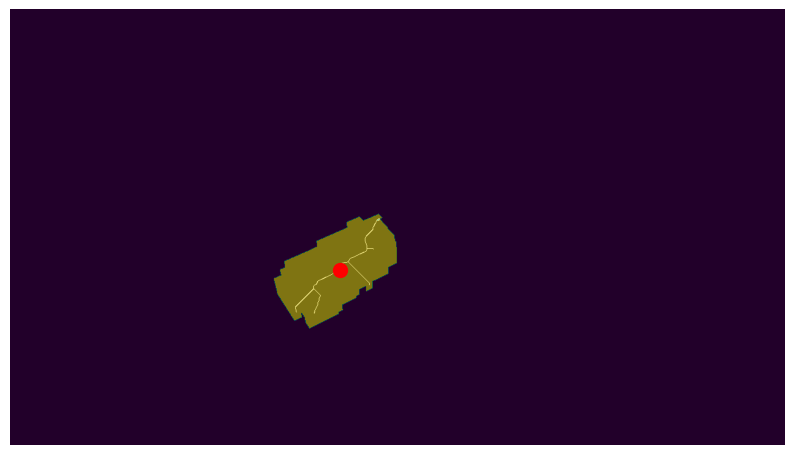

WTF


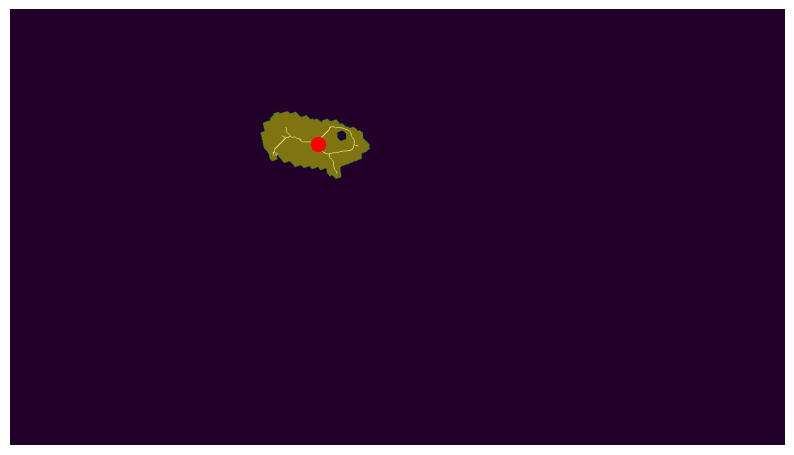

WTF


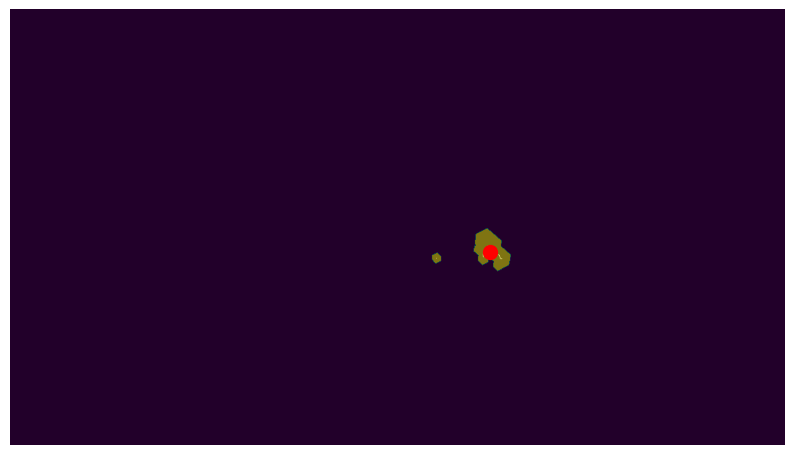

WTF


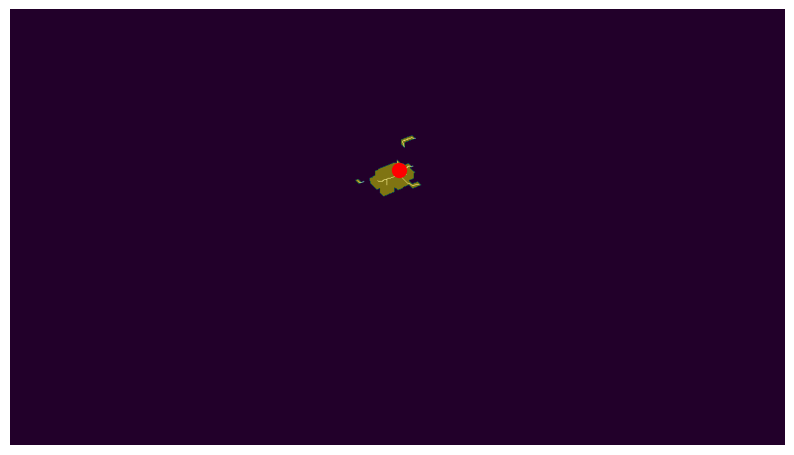

WTF


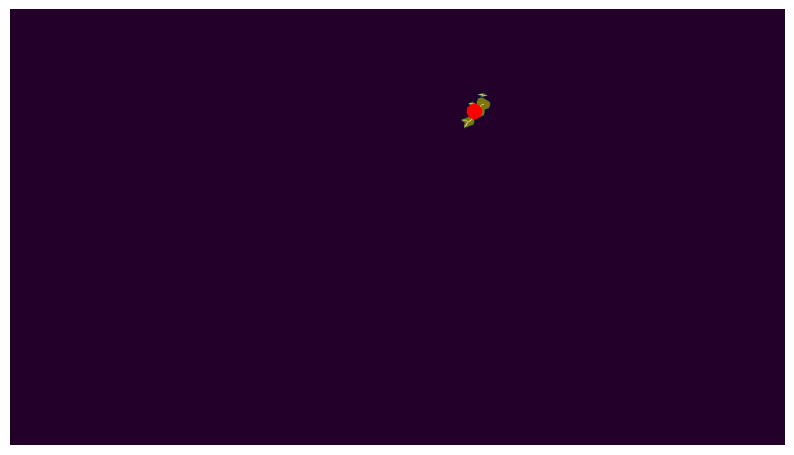

WTF


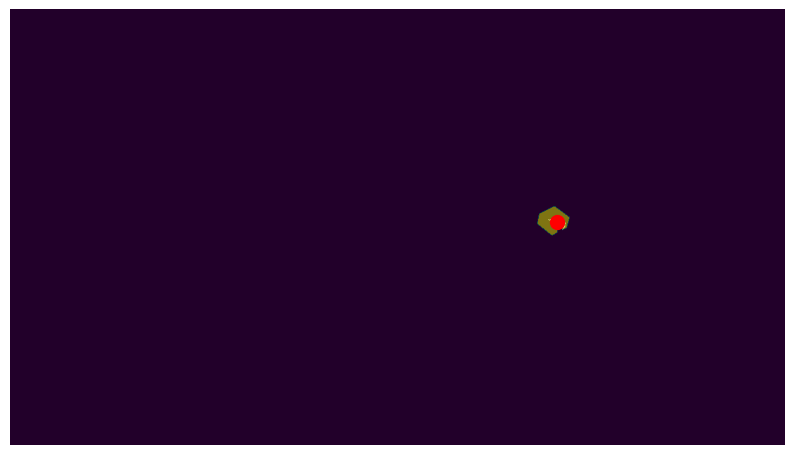

WTF


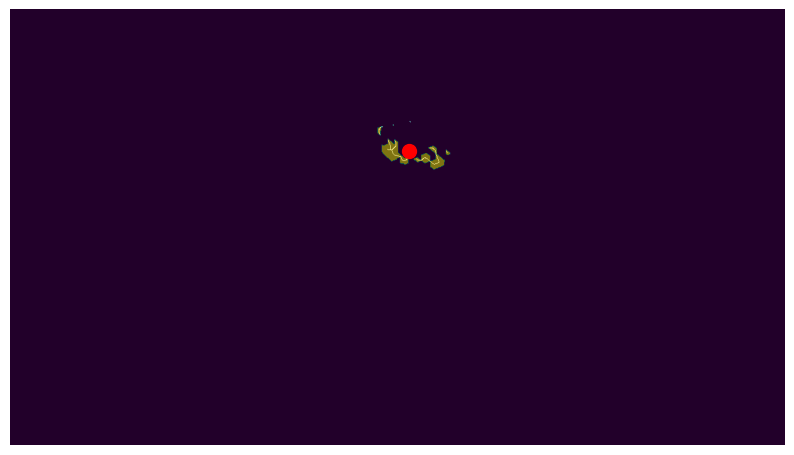

WTF


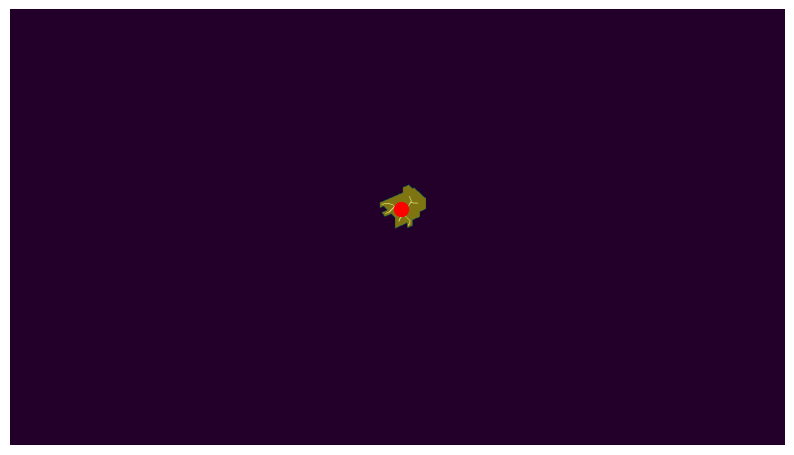

WTF


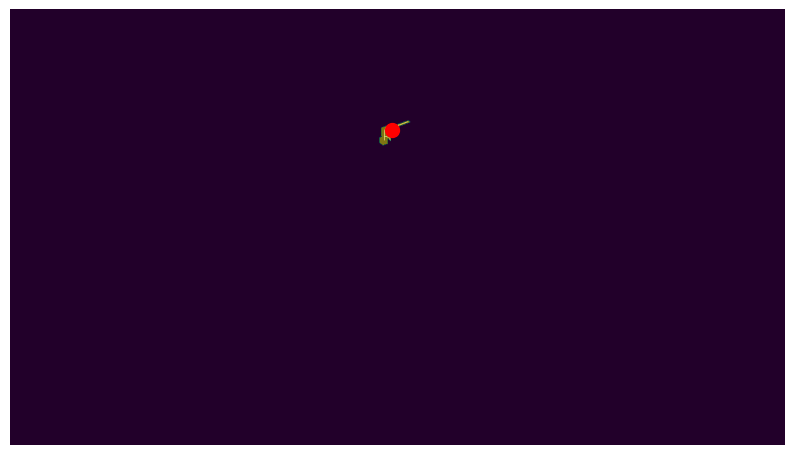

prompts generated


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [28]:

for image in scene.annotation_images.values():
    if image.annotation_accepted:
        continue
    rgb = cv2.imread(image.rgb_path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    predictor.set_image(rgb)
    generate_auto_prompts(image, scene, predictor)
    break